In [44]:
%cd '/content/drive/My Drive/NLP/twitter'

/content/drive/My Drive/NLP/twitter


In [45]:
!pip install fastai2 --quiet
!pip install kaggle --quiet

from fastai2.text.all import *

import warnings
warnings.filterwarnings('ignore')

KeyboardInterrupt: ignored

In [ ]:
!ls

In [46]:
train = pd.read_csv('/content/drive/My Drive/NLP/twitter/train.csv')
test = pd.read_csv('/content/drive/My Drive/NLP/twitter/test.csv')

In [47]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [68]:
train['text'].value_counts()

11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...        10
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                               6
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                      6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_     6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                  5
                                                                                                                                                ..
Literally trapped in my room Cuz my bathroom being remodeled. The only exit is through a window                       

In [69]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [70]:
txt = train['text'].iloc[0]
txt


'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [71]:
# Initializing the default tokenizer used in Fastai which is that of Spacy called `WordTokenizer`
spacy = WordTokenizer() 

# Wrapping the Spacy tokenizer with a custom Fastai function to make some custom changes to the tokenizer
tkn = Tokenizer(spacy) 

tkn(txt)


(#21) ['xxbos','xxmaj','our','xxmaj','deeds','are','the','xxmaj','reason','of'...]

In [72]:
txts = L([i for i in train['text']])
txts

(#7613) ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all','Forest fire near La Ronge Sask. Canada',"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",'13,000 people receive #wildfires evacuation orders in California ','Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ','#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires','#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',"I'm on top of the hill and I can see a fire in the woods...","There's an emergency evacuation happening now in the building across the street","I'm afraid that the tornado is coming to our area..."...]

In [73]:
# Setting up a tokenizer on the entire dataframe 'train'
tok = Tokenizer.from_df(train)
tok.setup(train)

toks = txts.map(tok)
toks[5]

(#29) ['xxbos','#','rockyfire','xxmaj','update','=','>','xxmaj','california','xxmaj'...]

In [74]:
toks[1000]

(#20) ['xxbos','#','ovofest','xxmaj','drake','straight','body','bagging','xxmaj','meek'...]

In [75]:
tok.decode(toks[0])


'xxbos xxmaj our xxmaj deeds are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all'

In [76]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10000]

tensor([   2,    8,  150,    8,    0,   43,   14,    8,  884,   19,   39,   13,
         300,    8,  169,    7, 1620,    8,    0,  120,   65])

In [77]:
num.encodes(toks[0])

TensorText([   2,    8,  150,    8,    0,   43,   14,    8,  884,   19,   39,   13,
         300,    8,  169,    7, 1620,    8,    0,  120,   65])

In [78]:
num.decode(nums[0][:100])

(#21) ['xxbos','xxmaj','our','xxmaj','xxunk','are','the','xxmaj','reason','of'...]

In [79]:
# dataset for fine-tuning language model which only needs the text data
df_lm = pd.concat([train, test], axis=0)[['text']]
df_lm.head()

,text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


In [80]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1) 
    # using only 10% of entire comments data for validation inorder to learn more
)

In [81]:
dls_lm = dls_lm.dataloaders(df_lm, bs=64, seq_len=72)

In [82]:
dls_lm.show_batch(max_n=100)

,text,text_
0,xxbos xxmaj falling asleep to the sounds to thousands of xxmaj river xxmaj plate fans in the stadium and a thunderstorm . # xxunk xxbos xxmaj spot xxmaj flood xxmaj combo 53inch 300w xxmaj curved xxmaj cree xxup led xxmaj work xxmaj light xxmaj bar 4x4 xxmaj offroad xxmaj fog xxmaj lamp - xxmaj full reû _ http : / / t.co / xxunk http : / / t.co / xxunk xxbos,xxmaj falling asleep to the sounds to thousands of xxmaj river xxmaj plate fans in the stadium and a thunderstorm . # xxunk xxbos xxmaj spot xxmaj flood xxmaj combo 53inch 300w xxmaj curved xxmaj cree xxup led xxmaj work xxmaj light xxmaj bar 4x4 xxmaj offroad xxmaj fog xxmaj lamp - xxmaj full reû _ http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxup
1,", stay safe everyone . xxbos 19 xxrep 3 0 homes destroyed in xxmaj gaza -- xxup zero xxunk . xxmaj join me in busting the xxunk ! xxmaj sign & & xxup rt # xxmaj gaza # xxunk https : / / t.co / xxunk m xxbos xxunk and he used xxunk on me also xxunk i was tea bagging your body for like 7 minutes while he was fighting someone",stay safe everyone . xxbos 19 xxrep 3 0 homes destroyed in xxmaj gaza -- xxup zero xxunk . xxmaj join me in busting the xxunk ! xxmaj sign & & xxup rt # xxmaj gaza # xxunk https : / / t.co / xxunk m xxbos xxunk and he used xxunk on me also xxunk i was tea bagging your body for like 7 minutes while he was fighting someone else
2,a boat xxrep 6 ? xxbos xxmaj watch : xxmaj violent xxmaj storm xxmaj causes xxmaj deadly xxmaj accident at xxmaj new xxmaj hampshire xxmaj circus http : / / t.co / xxunk # xxup xxunk http : / / t.co / xxunk xxbos xxmaj zouma ! xxmaj runaway train . xxmaj absolutely flattened the xxmaj xxunk player there … xxbos xxmaj motorcyclist bicyclist injured in xxmaj denver collision on xxmaj broadway,boat xxrep 6 ? xxbos xxmaj watch : xxmaj violent xxmaj storm xxmaj causes xxmaj deadly xxmaj accident at xxmaj new xxmaj hampshire xxmaj circus http : / / t.co / xxunk # xxup xxunk http : / / t.co / xxunk xxbos xxmaj zouma ! xxmaj runaway train . xxmaj absolutely flattened the xxmaj xxunk player there … xxbos xxmaj motorcyclist bicyclist injured in xxmaj denver collision on xxmaj broadway http
3,therefore it came to pass that in my xxunk year i did go forth at the head of an army of the … http : / / t.co / xxunk xxbos xxunk xxunk \n xxmaj well then we see things xxunk . xxbos # dating # meet # sex xxmaj hot xxmaj teen xxmaj ass xxmaj exploded xxmaj by xxmaj fat xxmaj cock http : / / t.co / xxunk xxbos #,it came to pass that in my xxunk year i did go forth at the head of an army of the … http : / / t.co / xxunk xxbos xxunk xxunk \n xxmaj well then we see things xxunk . xxbos # dating # meet # sex xxmaj hot xxmaj teen xxmaj ass xxmaj exploded xxmaj by xxmaj fat xxmaj cock http : / / t.co / xxunk xxbos # xxmaj
4,model 295ss-100 xxup siren xxup amplifier xxup police xxup emergency xxup vehicle - xxmaj full read by ebay http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj oh my xxmaj god . xxmaj sending my thoughts to xxunk head coach xxmaj dan xxmaj hughes who left the game on stretcher after xxmaj danielle xxmaj robinson collided into him . xxbos @raynbowaffair xxmaj editor xxmaj in,295ss-100 xxup siren xxup amplifier xxup police xxup emergency xxup vehicle - xxmaj full read by ebay http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj oh my xxmaj god . xxmaj sending my thoughts to xxunk head coach xxmaj dan xxmaj hughes who left the game on stretcher after xxmaj danielle xxmaj robinson collided into him . xxbos @raynbowaffair xxmaj editor xxmaj in xxmaj
5,xxunk xxmaj xxunk xxmaj and xxmaj near xxmaj death xxmaj experiences http : / / t.co / xxunk km xxunk xxunk xxunk xxbos xxmaj the xxmaj prophet ( peace be upon him ) said ' save yourself from xxmaj hellfire even if it is by giving half a date in charity . ' xxbos xxmaj that xxunk has n't already collapsed is a xxunk to xxunk xxunk xxunk to politics over reality,xxmaj xxunk xxmaj and xxmaj near xxmaj death xxma

In [83]:
# Saving the dataloader for fast use in the future

torch.save(dls_lm, '/content/drive/My Drive/NLP/twitter/disaster_tweets_dls_lm.pkl')


In [84]:
# To load the Dataloaders in the future

dls_lm = torch.load('/content/drive/My Drive/NLP/twitter/disaster_tweets_dls_lm.pkl')


In [85]:
learn = language_model_learner(
    dls_lm, AWD_LSTM,
    metrics=[accuracy, Perplexity()]).to_fp16()

In [86]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(5832, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(5832, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=5832, bias=True)
    (output_dp): RNNDropout()
  )
)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.04786301031708717)

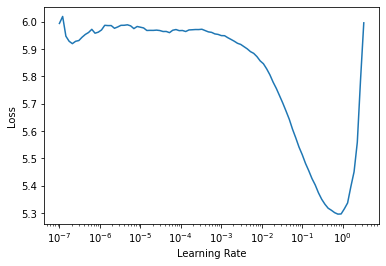

In [87]:
learn.lr_find()


In [88]:
learn.fine_tune(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.982881,3.664949,0.392485,39.054161,00:42


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.889367,3.376483,0.421583,29.267668,00:50
1,3.628446,3.149867,0.448497,23.332968,00:50
2,3.400688,3.049626,0.464086,21.107447,00:50
3,3.238569,3.005134,0.471018,20.188923,00:50
4,3.139229,2.997877,0.473011,20.042938,00:50


In [89]:
learn.save_encoder('/content/drive/My Drive/NLP/twitter/models/finetuned')


In [90]:
blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, max_vocab=6000), CategoryBlock())
dls = DataBlock(blocks=blocks,
                get_x=ColReader('text'),
                get_y=ColReader('target'),
                splitter=RandomSplitter(0.1))

In [91]:
dls = dls.dataloaders(train, bs=64)

In [92]:
dls.show_batch(max_n=100)

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n\n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g xxpad,0
2,xxbos i xxmaj hate xxmaj to xxmaj talking xxmaj xxunk xxmaj with xxmaj my xxmaj xxunk … i xxmaj mean i xxmaj love xxmaj her xxmaj as xxmaj to xxmaj death xxmaj but xxmaj she xxmaj talk xxmaj so xxmaj damn xxmaj much xxmaj xxunk xxrep 3 h xxrep 3 e xxunk xxrep 3 ! xxrep 6 ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
3,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
4,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1
5,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
6,xxbos xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1
7,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1
8,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1
9,xxbos xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1


In [93]:
len(dls.train_ds), len(dls.valid_ds)

(6852, 761)

In [94]:
torch.save(dls_lm, '/content/drive/My Drive/NLP/twitter/realOrNot_dls_cls.pkl')

In [95]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, FBeta(beta=1)]).to_fp16()


In [97]:
learn.load_encoder('/content/drive/My Drive/NLP/twitter/models/finetuned')

RuntimeError: ignored

In [98]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.688824,0.472043,0.779238,0.715254,00:19


In [99]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.615886,0.465478,0.781866,0.708772,00:20


In [100]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.505328,0.451481,0.806833,0.750424,00:24


In [101]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),3e-3))


epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.448591,0.459861,0.779238,0.735849,00:30
1,0.424546,0.465019,0.792378,0.732203,00:29


In [103]:
learn.save('final_model')